In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
import itertools

from tqdm import tqdm
import os
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import losses
from keras import layers, Sequential

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [49]:
CLASS_NAMES = ['sehat', 'giberella', 'anthracnose']

def load_data(path):

    images = []
    labels = []

    print("Loading {}".format(path))

    # Iterate through each folder corresponding to a category
    for i, folder in enumerate(CLASS_NAMES):
        label = i
        for file in tqdm(os.listdir(os.path.join(path, folder))):

            # Get the path name of the image
            img_path = os.path.join(os.path.join(path, folder), file)

            # Open and resize the img
            image = cv2.imread(img_path, 1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

    images = tf.convert_to_tensor(images, dtype=tf.uint8)
    labels = tf.convert_to_tensor(labels, dtype=tf.uint8)

    return (images, labels)

In [50]:
def show_sample_images(data, n_images):

    images, labels = data

    fig, axs = plt.subplots(nrows=n_images, ncols=len(CLASS_NAMES), figsize=(9, 10),
                            subplot_kw={'xticks': [], 'yticks': []})

    for col in range(len(CLASS_NAMES)):
        sample = images[labels==col][:n_images]
        for row in range(n_images):
            axs[row][col].imshow(sample[row])
            axs[row][col].set_title(CLASS_NAMES[col])

    plt.tight_layout()
    plt.show()

In [51]:
def plot_distribution_data(train_data, val_data, test_data):
    amount = {
        'Train': [ 0 for _ in range(len(np.unique(train_data))) ],
        'Val': [ 0 for _ in range(len(np.unique(train_data))) ],
        'Test': [ 0 for _ in range(len(np.unique(train_data))) ],
    }

    # count amount of data train
    for clas in train_data:
        amount['Train'][clas] += 1

    # count amount of data val
    for clas in val_data:
        amount['Val'][clas] += 1

    # count amount of data test
    for clas in test_data:
        amount['Test'][clas] += 1

    x = np.arange(len(CLASS_NAMES))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in amount.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Total')
    ax.set_title('Data distribution by classes')
    ax.set_xticks(x + width, CLASS_NAMES)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 100)

    plt.show()

In [52]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(10,10))

    axs[0].plot(history['loss'])
    axs[0].plot(history['val_loss'])
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Train','Val'])

    axs[1].plot(history['accuracy'])
    axs[1].plot(history['val_accuracy'])
    axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim(0, 1)
    axs[1].legend(['Train', 'Val'])

In [53]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# VGG16

## Data original

In [54]:
X_train, y_train = load_data("/content/drive/MyDrive/klasifikasi-daun-jagung/dataset/original/train")
X_train = X_train / 255

X_val, y_val = load_data("/content/drive/MyDrive/klasifikasi-daun-jagung/dataset/original/val")
X_val = X_val / 255

X_test, y_test = load_data("/content/drive/MyDrive/klasifikasi-daun-jagung/dataset/original/test")
X_test = X_test / 255

Loading /content/drive/MyDrive/klasifikasi-daun-jagung/dataset/original/train


100%|██████████| 64/64 [00:03<00:00, 20.11it/s]


Loading /content/drive/MyDrive/klasifikasi-daun-jagung/dataset/original/val


100%|██████████| 16/16 [00:00<00:00, 18.49it/s]


Loading /content/drive/MyDrive/klasifikasi-daun-jagung/dataset/original/test


100%|██████████| 20/20 [00:01<00:00, 13.86it/s]


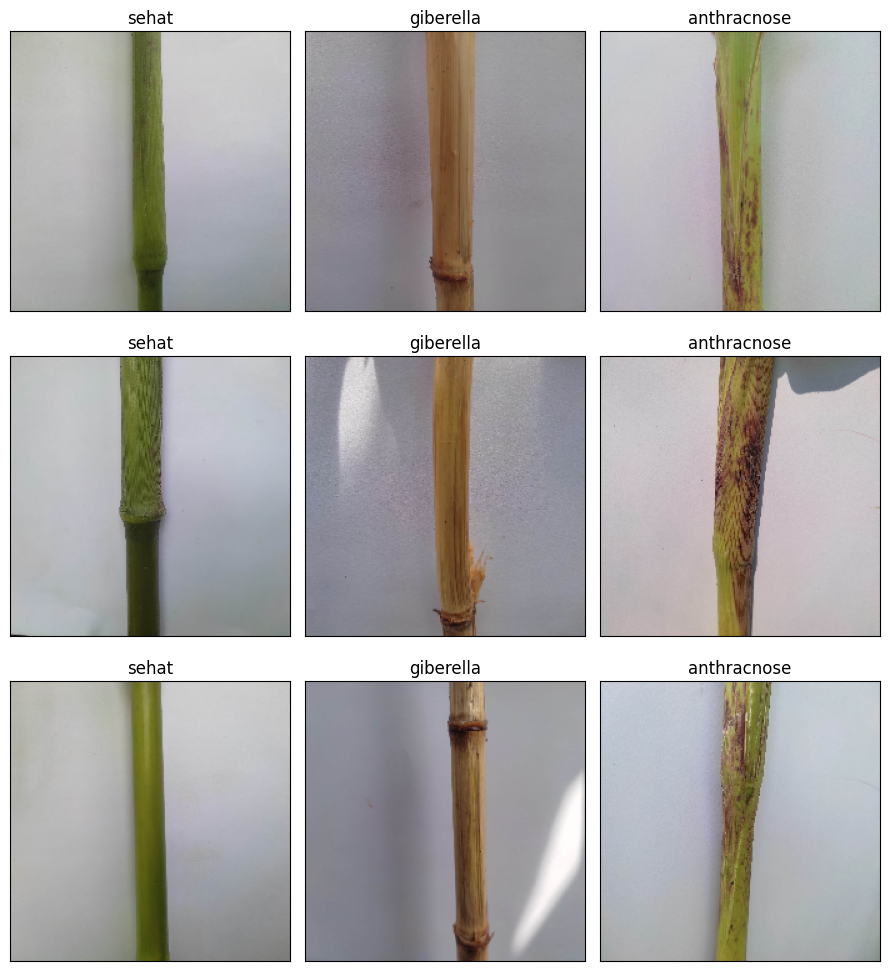

In [55]:
show_sample_images(data=(X_train, y_train), n_images=3)

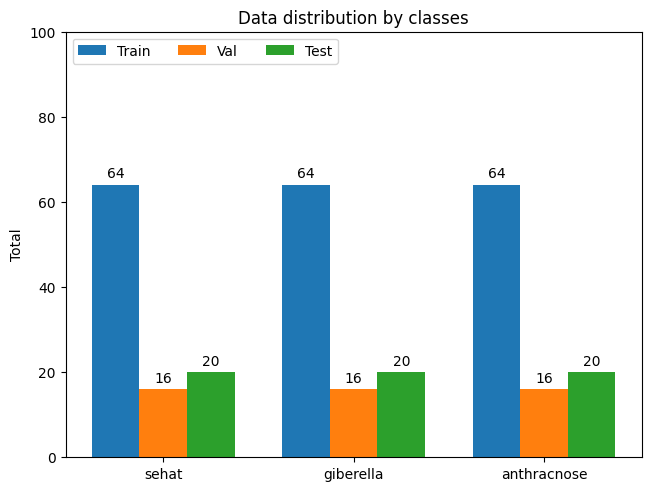

In [56]:
plot_distribution_data(y_train, y_val, y_test)

### SGD optimizer

In [57]:
model = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    classes=3,
    classifier_activation='softmax'
)

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [58]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg16-original-sgd.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.3730 - loss: 1.0985
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg16-original-sgd.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3673 - loss: 1.0985 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.3405 - loss: 1.0986
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 576ms/step - accuracy: 0.3394 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.3352 - loss: 1.0986
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 574ms/step - accuracy: 0.3350 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.3366 - loss: 1.0986
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - accuracy: 0.3362 - loss: 1.

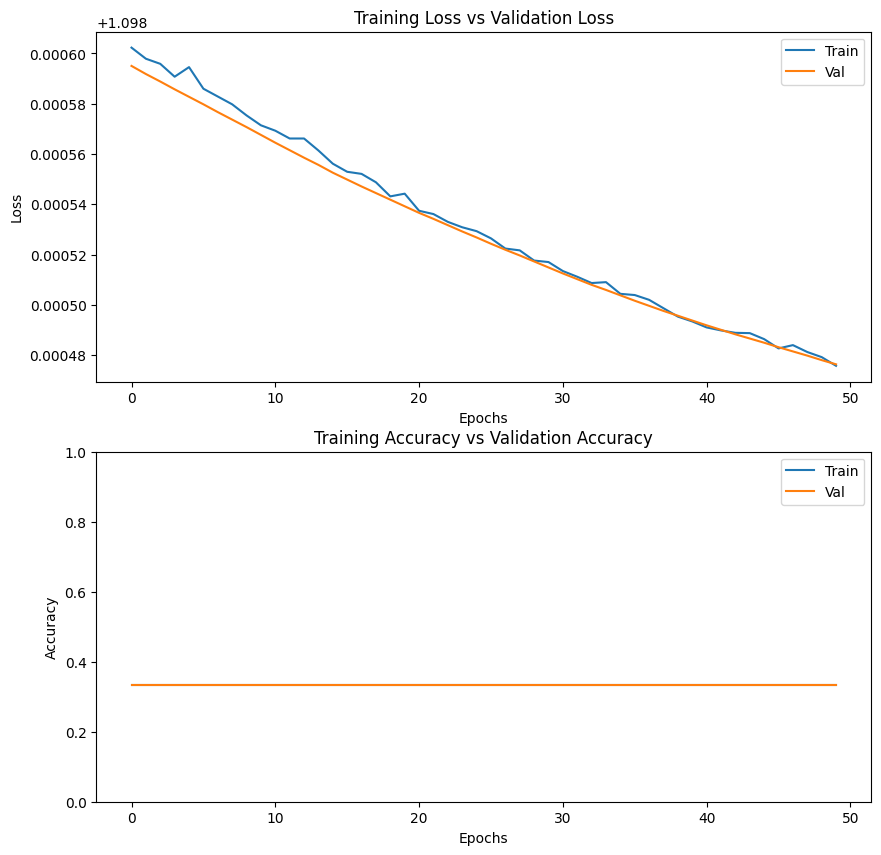

In [59]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step


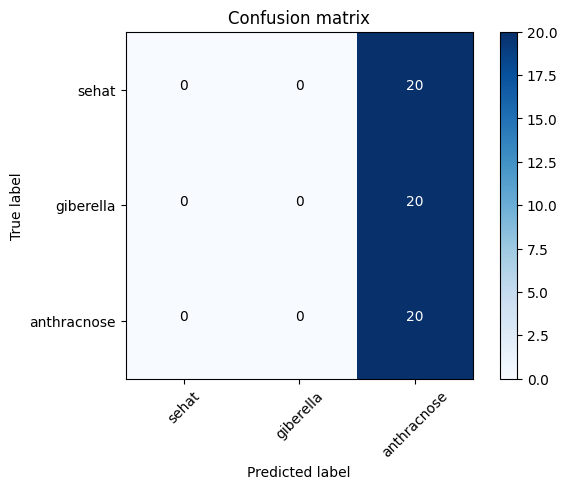

In [60]:
model.load_weights('vgg16-original-sgd.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)


In [75]:
!cp vgg16-original-sgd.weights.h5 /content/drive/MyDrive/klasifikasi-daun-jagung/model-weights

### RMSProp optimizer

### Adam optimizer

# VGG19

## Data original

### SGD optimizer

In [71]:
model = tf.keras.applications.VGG19(
    include_top=True,
    weights=None,
    classes=3,
    classifier_activation='softmax'
)

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [72]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg19-original-sgd.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.3778 - loss: 1.0986
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg19-original-sgd.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3714 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.3339 - loss: 1.0986
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 646ms/step - accuracy: 0.3338 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.3420 - loss: 1.0986
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 656ms/step - accuracy: 0.3408 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.3087 - loss: 1.0986
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 662ms/step - accuracy: 0.3122 - loss: 1.

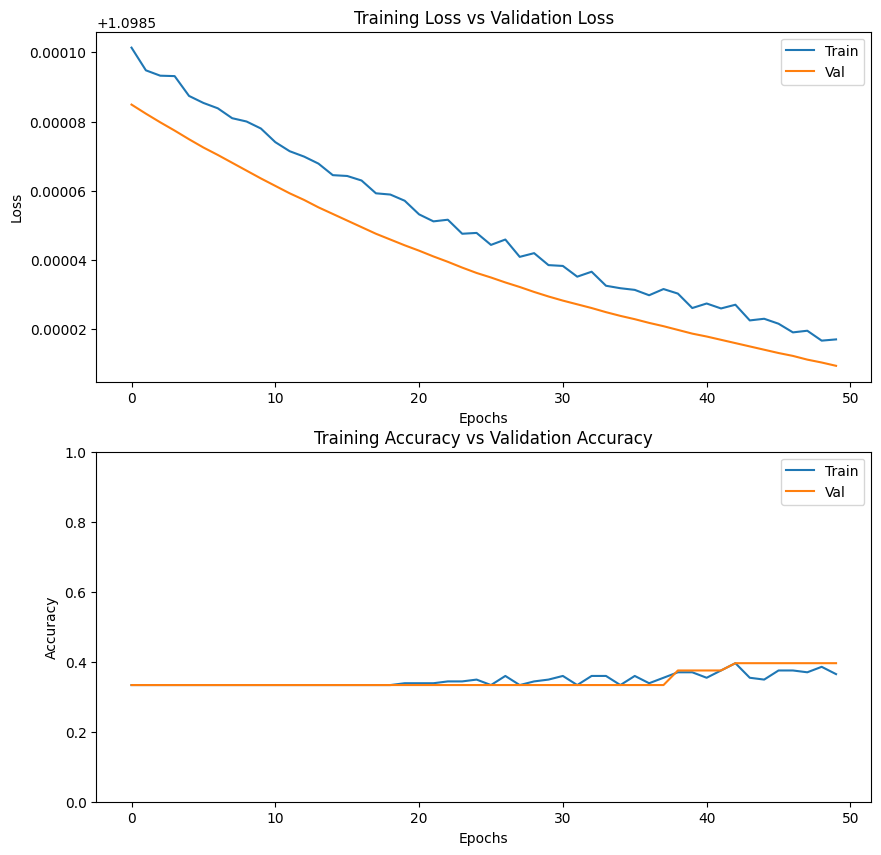

In [73]:
plot_history(history.history)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


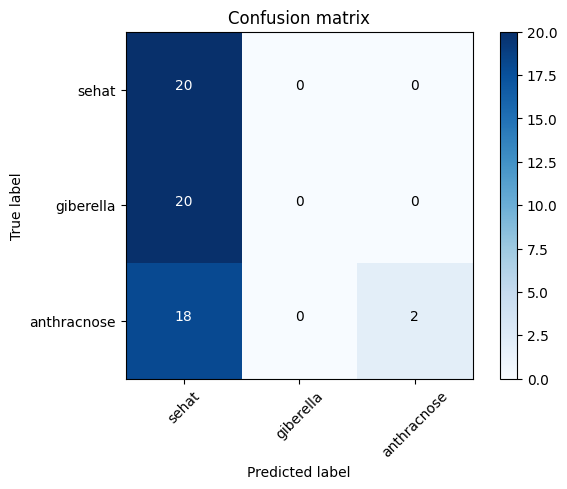

In [74]:
model.load_weights('vgg19-original-sgd.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [76]:
!cp vgg19-original-sgd.weights.h5 /content/drive/MyDrive/klasifikasi-daun-jagung/model-weights

# AlexNet

# ResNet101

In [64]:
import os

for version in os.listdir('/content/drive/MyDrive/klasifikasi-daun-jagung/dataset'):
    for section in os.listdir(os.path.join('/content/drive/MyDrive/klasifikasi-daun-jagung/dataset/', version)):
        for label in os.listdir(os.path.join('/content/drive/MyDrive/klasifikasi-daun-jagung/dataset/', version, section)):
            print(label, len(os.listdir(os.path.join('/content/drive/MyDrive/klasifikasi-daun-jagung/dataset/', version, section, label))))

anthracnose 64
giberella 64
sehat 64
anthracnose 16
giberella 16
sehat 16
anthracnose 20
giberella 20
sehat 20
anthracnose 64
giberella 64
sehat 64
anthracnose 16
giberella 16
sehat 16
anthracnose 20
giberella 20
sehat 20
